## Example Notebook

Examples used for EUFN Talk.


In [1]:
%load_ext autoreload
%autoreload 2


from fibsem import utils, acquire, movement
from fibsem.structures import BeamType, Point, FibsemImage, FibsemStagePosition

import numpy as np
import matplotlib.pyplot as plt
import os

Default configuration: default-configuration
Default configuration path: c:\users\luis-work\desktop\others\openfibsem\git-rfi-fibsem\fibsem\config\microscope-configuration.yaml


In [3]:
# connect to microscope
# microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")
microscope, settings = utils.setup_session(manufacturer="Demo", ip_address="localhost")


2024-04-24 09:44:26,176 — root — INFO — connect_to_microscope:5150 — Microscope client connected to DemoMicroscope with serial number 123456 and software version 0.1
2024-04-24 09:44:26,177 — root — INFO — setup_session:213 — Finished setup for session: demo_2024-04-24-09-44-26AM


### Imaging Example I

Take an image with the Electron Beam

In [4]:
from fibsem import acquire
from fibsem.structures import ImageSettings

# image settings
image_settings = ImageSettings(
    resolution = [1536, 1024], 
    dwell_time=1.0e-6,
    hfw=80-6,
    beam_type=BeamType.ELECTRON,
    autocontrast=True,
)

# acquire image
image = acquire.new_image(microscope, image_settings)

2024-04-24 09:44:30,916 — root — INFO — acquire_image:5167 — acquiring new ELECTRON image.


### Imaging Example II

Take an image with both beams at different hfws, and plot.


In [5]:
settings.image.beam_type = BeamType.ION
settings.image.autocontrast = False
settings.image.save = True
settings.image.path = os.path.join(os.getcwd(), "demo", "imaging")
os.makedirs(settings.image.path, exist_ok=True)


settings.image.hfw = 80e-6

hfws = [80e-6, 150e-6, 400e-6, 900e-6]
for i, hfw in enumerate(hfws):

    settings.image.hfw = hfw
    settings.image.filename = f"hfws_{i:02d}"

    ib_image = acquire.new_image(microscope, settings.image)


2024-04-24 09:44:35,117 — root — INFO — acquire_image:5167 — acquiring new ION image.
2024-04-24 09:44:35,126 — root — INFO — acquire_image:5167 — acquiring new ION image.
2024-04-24 09:44:35,136 — root — INFO — acquire_image:5167 — acquiring new ION image.
2024-04-24 09:44:35,147 — root — INFO — acquire_image:5167 — acquiring new ION image.


### Loading Images, Reading Metadata

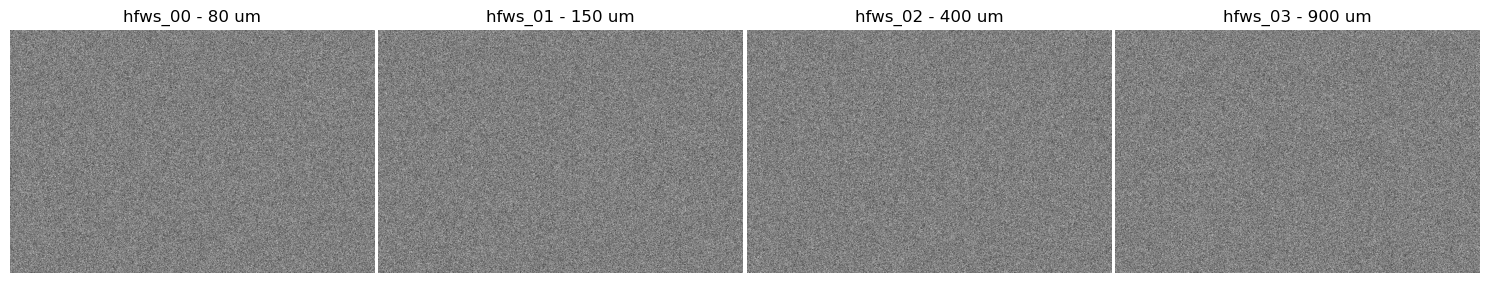

In [6]:
# loading images

import glob
from fibsem.structures import FibsemImage

filenames = sorted(glob.glob(os.path.join(settings.image.path, "hfws*.tif")))

# plot wiht subplot
fig, axes = plt.subplots(1, len(filenames), figsize=(15, 5))
for fname in filenames:

    image = FibsemImage.load(fname)
    ax = axes[filenames.index(fname)]
    ax.imshow(image.data, cmap="gray")
    ax.set_title(f"{image.metadata.image_settings.filename} - {image.metadata.image_settings.hfw*1e6:.0f} um")
    ax.axis("off")

# subplot width
plt.tight_layout()

# hwidth
plt.subplots_adjust(wspace=0.01)

# save fig, dpi = 300
plt.savefig(os.path.join(settings.image.path, "hfws.png"), dpi=300)

plt.show()
    


### Stage Movement

Basic stage movement, and plotting.

2024-04-24 09:44:45,664 — root — INFO — acquire_image:5167 — acquiring new ELECTRON image.
2024-04-24 09:44:45,674 — root — INFO — acquire_image:5167 — acquiring new ION image.
2024-04-24 09:44:45,686 — root — INFO — acquire_image:5167 — acquiring new ELECTRON image.
2024-04-24 09:44:45,695 — root — INFO — acquire_image:5167 — acquiring new ION image.


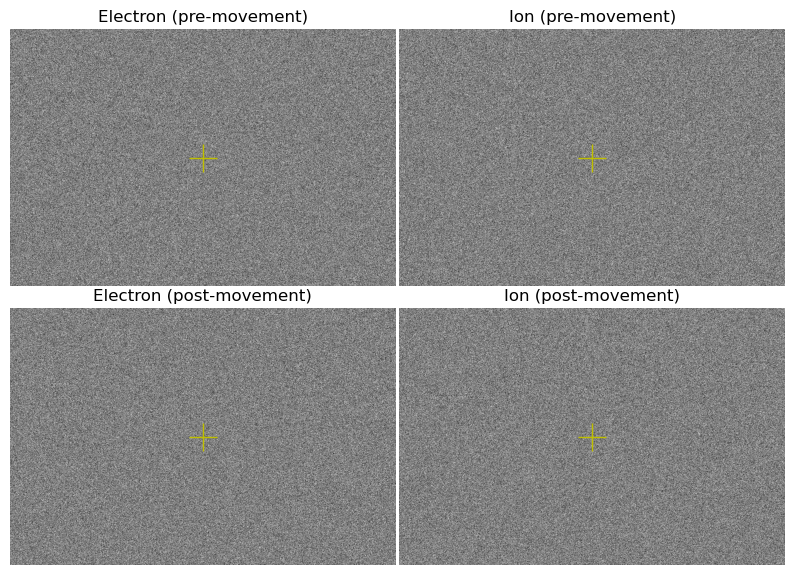

In [7]:
# image settings
settings.image.hfw = 150e-6
settings.image.save = True
settings.image.path = os.path.join(os.getcwd(), "demo", "movement")
os.makedirs(settings.image.path, exist_ok=True)

# acquire images with both beams
settings.image.filename = "pre-movement"
eb_image0, ib_image0 = acquire.take_reference_images(microscope, settings.image)

# move stage by 50um
move_position = FibsemStagePosition(x=50e-6)
microscope.move_stage_relative(move_position)

# acquire images with both beams
settings.image.filename = "post-movement"
eb_image1, ib_image1 = acquire.take_reference_images(microscope, settings.image)



# plot images
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes[0][0].imshow(eb_image0.data, cmap="gray")
axes[0][0].set_title("Electron (pre-movement)")
# crosshair, centre, yellow
axes[0][0].plot(eb_image0.data.shape[1]/2, eb_image0.data.shape[0]/2, "y+", ms=20)
axes[0][1].imshow(ib_image0.data, cmap="gray")
axes[0][1].set_title("Ion (pre-movement)")
axes[0][1].plot(ib_image0.data.shape[1]/2, ib_image0.data.shape[0]/2, "y+", ms=20)

axes[1][0].imshow(eb_image1.data, cmap="gray")
axes[1][0].set_title("Electron (post-movement)")
# crosshair, centre, yellow
axes[1][0].plot(eb_image1.data.shape[1]/2, eb_image1.data.shape[0]/2, "y+", ms=20)
axes[1][1].imshow(ib_image1.data, cmap="gray")
axes[1][1].set_title("Ion (post-movement)")
axes[1][1].plot(ib_image1.data.shape[1]/2, ib_image1.data.shape[0]/2, "y+", ms=20)

# axes off
for ax in axes.flatten():
    ax.axis("off")

# wspace
plt.subplots_adjust(hspace=0.07, wspace=0.01)

# save fig, dpi = 300
plt.savefig(os.path.join(settings.image.path, "movement.png"), dpi=300)

plt.show()


## Scripting Examples

### Rotation Example

Rotate the stage, and take an image at each step (15deg).

In [9]:
from fibsem import utils, acquire
from fibsem.structures import FibsemStagePosition
import os

# connect to microscope
#microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")
microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")

# image settings
settings.image.save = True 
settings.image.path = os.path.join(os.getcwd(), "demo", "rotation")
os.makedirs(settings.image.path, exist_ok=True)

rot = 30    # rotation angle
for i in range(360//rot):
    
    # move stage relative
    microscope.move_stage_relative(FibsemStagePosition(r=np.deg2rad(rot)))

    # acquire images with both beams
    settings.image.filename = f"rot_{i:03d}"
    eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

2024-04-24 09:45:05,641 — root — INFO — connect_to_microscope:5150 — Microscope client connected to DemoMicroscope with serial number 123456 and software version 0.1
2024-04-24 09:45:05,642 — root — INFO — setup_session:213 — Finished setup for session: demo_2024-04-24-09-45-05AM
2024-04-24 09:45:05,644 — root — INFO — acquire_image:5167 — acquiring new ELECTRON image.
2024-04-24 09:45:05,657 — root — INFO — acquire_image:5167 — acquiring new ION image.
2024-04-24 09:45:05,669 — root — INFO — acquire_image:5167 — acquiring new ELECTRON image.
2024-04-24 09:45:05,681 — root — INFO — acquire_image:5167 — acquiring new ION image.
2024-04-24 09:45:05,691 — root — INFO — acquire_image:5167 — acquiring new ELECTRON image.
2024-04-24 09:45:05,700 — root — INFO — acquire_image:5167 — acquiring new ION image.
2024-04-24 09:45:05,708 — root — INFO — acquire_image:5167 — acquiring new ELECTRON image.
2024-04-24 09:45:05,718 — root — INFO — acquire_image:5167 — acquiring new ION image.
2024-04-24 

## Tiling Example

Take a 3x3 tile scan with the ION beam and plot.

In [ ]:
from fibsem import utils, acquire
from fibsem.structures import FibsemStagePosition
import os

# connect to microscope
#microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")
microscope, settings = utils.setup_session(manufacturer="Demo", ip_address="localhost")

# image settings
settings.image.hfw = 80e-6
settings.image.resolution = [1024, 1024]
settings.image.beam_type = BeamType.ION
settings.image.save = True 
settings.image.path = os.path.join(os.getcwd(), "demo", "tile")
os.makedirs(settings.image.path, exist_ok=True)

# tile settings
dx, dy = settings.image.hfw, settings.image.hfw
nrows, ncols = 3, 3

# tile
initial_position = microscope.get_stage_position()
for i in range(nrows):

    # restore position
    microscope.move_stage_absolute(initial_position)
    # stable movement dy
    microscope.stable_move(dx=0, dy=dy*i, beam_type=BeamType.ION)

    for j in range(ncols):
    
        # stable movement dx
        microscope.stable_move(dx=dx, dy=0, beam_type=BeamType.ION)
        # acquire images with both beams
        settings.image.filename = f"tile_{i:03d}_{j:03d}"
        ib_image = acquire.new_image(microscope, settings.image)

In [ ]:
# plot tiles
import glob
filenames = sorted(glob.glob(os.path.join(settings.image.path, "tile*.tif")))


fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
for fname in filenames:

    image = FibsemImage.load(fname)
    ax = axes[filenames.index(fname)//ncols][filenames.index(fname)%ncols]
    ax.imshow(image.data, cmap="gray")
    ax.axis("off")

# subplot width
plt.tight_layout()

# hwidth
plt.subplots_adjust(hspace=0.01,wspace=0.01)

# save fig, dpi = 300
plt.savefig(os.path.join(settings.image.path, "tiles.png"), dpi=300)

plt.show()

## Serialisation

Writing / Reading structures to disk

In [ ]:
from fibsem.structures import MicroscopeState
os.makedirs("demo/state", exist_ok=True)

# get state
print("\nCurrent microscope state:")
state = microscope.get_microscope_state()

# save to yaml
print("\nSerialise microscope state")
state_dict = state.to_dict()
utils.save_yaml("demo/state/state.yaml", state_dict)

# load from yaml
print("\nDeserialise microscope state")
state_dict = utils.load_yaml("demo/state/state.yaml")
state = MicroscopeState.from_dict(state_dict)

## Model Deployment

In [10]:
from fibsem import utils, acquire
from fibsem.detection import detection
from fibsem.detection import detection
from fibsem.segmentation.model import load_model
from fibsem.structures import BeamType

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Demo", ip_address="localhost")

# model parameters
checkpoint = "autolamella-mega-latest.pt"

# load model
model = load_model(checkpoint=checkpoint) # type: ignore

# acquire image
settings.image.beam_type = BeamType.ION
image = acquire.new_image(microscope, settings.image)

# detect features
features = [detection.NeedleTip(), detection.LamellaCentre()] 
det = detection.detect_features(image=image.data, model=model, 
                                features=features,                      # type: ignore        
                                pixelsize=image.metadata.pixel_size.x)  # type: ignore 

# plot detection
detection.plot_detection(det)

c:\Users\Luis-work\miniconda3\envs\franklin_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-04-24 09:46:07,125 — root — INFO — connect_to_microscope:5150 — Microscope client connected to DemoMicroscope with serial number 123456 and software version 0.1
2024-04-24 09:46:07,126 — root — INFO — setup_session:213 — Finished setup for session: demo_2024-04-24-09-46-07AM


EntryNotFoundError: 404 Client Error. (Request ID: Root=1-6628c6cf-6d6475dd61b6c13c39ce4582;9fa8154b-b6fe-4b2f-8402-5f0d2f83f100)

Entry Not Found for url: https://huggingface.co/patrickcleeve/autolamella/resolve/main/autolamella-mega-latest.pt.

In [ ]:
# model
%load_ext autoreload
%autoreload 2

from fibsem import utils, acquire
from fibsem.detection import detection
from fibsem.segmentation import model
from fibsem.detection import detection
from fibsem.detection.detection import DetectedFeatures
from fibsem.segmentation import model as fibsem_model
from fibsem.segmentation.model import load_model
from fibsem.structures import (
    BeamType,
    FibsemImage,
    Point,
)

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Demo", ip_address="localhost")

# model parameters
checkpoint = "autolamella-mega-latest.pt"

# load model
model = load_model(checkpoint=checkpoint) # type: ignore

# load image
image = FibsemImage.load("../fibsem/detection/test_image.tif")

# detect features
features = [detection.NeedleTip(), detection.LamellaCentre()] 
det = detection.detect_features(image=image.data, model=model, 
                                features=features, pixelsize=25e-9) # type: ignore 

# plot detection
detection.plot_detection(det)



### EUFN Live Example - Focus Stacking



In [ ]:
import os, logging
import matplotlib.pyplot as plt
import numpy as np
from fibsem import utils, acquire
from fibsem.structures import BeamType

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Thermo", ip_address="localhost") 

# setup
microscope.set("on", True, BeamType.ELECTRON )
microscope.set("on", True, BeamType.ION )

# image settings
settings.image.resolution = [6144, 4096]
settings.image.dwell_time = 200e-9
settings.image.hfw = 500e-6
settings.image.autocontrast = True
settings.image.save = True
settings.image.path = os.path.join(os.getcwd(), "demo", "eufn")
os.makedirs(settings.image.path, exist_ok=True)
# NB: no line integration

wds = np.arange(0.004, 0.0048, 50e-6)
images = []

logging.info(f"Acquiring {len(wds)} images")

for wd in wds:

    logging.info(f"Working distance: {wd:4e}")
    microscope.set("working_distance", wd, BeamType.ELECTRON)

    settings.image.filename = f"wd_{wd:.4e}".replace(".", "_")

    image = acquire.new_image(microscope, settings.image)

    images.append(image)
    logging.info(f"-"*200)

# lapacian pyramid
# TODO: stacking.py
# stacking.image_stacking(images)

In [ ]:

# plot images as grid
fig, axes = plt.subplots(len(images)//4, len(images)//4, figsize=(10, 10))

for i, image in enumerate(images):
    ax = axes[i//4, i%4]
    ax.imshow(image.data, cmap="gray")
    ax.set_title(f"WD: {wds[i]:.08f}")
    ax.axis("off")
# subplot width
plt.tight_layout()

# hwidth
plt.subplots_adjust(hspace=0.01,wspace=0.01)

plt.show()